<H1><center>Capstone Project</center></H1><img src="https://pngimage.net/wp-content/uploads/2018/05/crossfit-logo-png-4.png" align="center" width="200">
<H2><center>Crossfit Athletes</center></H2><H3><center>Predicting Results and Analysing Profiles</center></H3>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology - Prediction Task](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

On this project, the Data Scientist is (imagining to be) working with **Ben Bergeron**, coach of the fittest Crossfit athletes in the Crossfit Games History, **Katrin Tanja Davidsdottir** and **Matt Fraser**. 
<p><b>Ben</b> is a methodic and analytical coach who keeps track of all the data pertaining his and other athletes. When he found out that <b>Crossfit.com</b> had released a dataset with benchmark and weightlifting results from over 400k athletes, he reached out to me to discuss what we could do with this precious data. <p>He showed particular interest in profiling athletes and figuring out what the competition looked like for the next Games. Furthermore, he also wondered if we could train an AI algorithm to estimate the maximum potential of his athletes in Olympic lifts based on basic strength tests.

## Data <a name="data"></a>

First step - The prediction task:
* aiming to predict the expected Olympic lifts: Snatch and Clean&Jerk;
* for which a correlation analysis will be done, to decide which independent variables are good candidates for prediction.

Second step - Profiling:
* athletes are usually subjected to two types of exercise: Endurance or Strength; 
* top athletes are balanced and fit in both types, but usually tend to be best at one or the other;
* this might be influenced by weight, height or age.

In [1]:
# Installing libraries and stuff
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 

print('Yes, master!')

Yes, master!


In [2]:
# Making a couple of changes to how Pandas display dataframes
pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

print('As you wish.')

As you wish.


In [3]:
# Open the CSV and save it in a Dataframe
athletes = pd.read_csv('athletes.csv')
athletes.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(423006, 28)

In [4]:
# For a matter of simplicity and computational speed we will drop from the dataset all athletes that have given
# incomplete questionaires. Possibly, some NaN values could be replaced by the mean or mode of their respective sets,
# but for the purpose of this exercise we'll just drop all incomplete.
athletes = athletes.dropna()
athletes.shape

(705, 28)

In [5]:
ath_df = athletes.drop(columns=['athlete_id','name','team','affiliate','retrieved_datetime', 'region'])

## Methodology - Prediction Task <a name="methodology"></a>

In this first task, data has to be processed in order to make it suitable for a **correlation analysis**, for which a **heatmap** will be plotted as a way of visually identifying the best candidates for prediction with **Multiple Linear Regression (MLR)**.

## Analysis - Prediction Task <a name="analysis"></a>

Many variables are categorical, making it necessary to create numerical substitutes that will allow for euclidian distances to be computed:

In [6]:
# Create new columns for numerical substitutes
ath_df['eatN'] = ath_df.apply(lambda _: '', axis=1)
ath_df['trainN'] = ath_df.apply(lambda _: '', axis=1)
ath_df['backgroundN'] = ath_df.apply(lambda _: '', axis=1)
ath_df['experienceN'] = ath_df.apply(lambda _: '', axis=1)
ath_df['scheduleN'] = ath_df.apply(lambda _: '', axis=1)
ath_df['howlongN'] = ath_df.apply(lambda _: '', axis=1)
ath_df['genderN'] = ath_df.apply(lambda _: '', axis=1)

In [7]:
ath_df.howlong.unique()

array(['6-12 months|', '2-4 years|', '4+ years|', '1-2 years|',
       '1-2 years|2-4 years|', 'Less than 6 months|2-4 years|',
       'Less than 6 months|', 'Decline to answer|', '2-4 years|4+ years|',
       'Less than 6 months|1-2 years|', '6-12 months|1-2 years|',
       'Less than 6 months|4+ years|'], dtype=object)

In [8]:
# Numerical direct substitutes: Gender
lm = preprocessing.LabelEncoder()

lm.fit(ath_df.gender.unique())
ath_df['genderN'] = lm.transform(ath_df['gender']) 

For some variables, in which athlete responses were concatenated within one cell, the string has to be split and transported to individual cells with binary encoding, indicating the existence or absence of a specific answer for a given athlete.

In [9]:
# Splitting Schedule and Howlong
ath_df['schedule'] = ath_df.schedule.str.split('|')
ath_df['howlong'] = ath_df.howlong.str.split('|')

In [10]:
#Copying the dataframe into a new one
athsplit_df = ath_df.copy()

#For every row in the dataframe, iterate through the list of schedule and howlong and place a 1 into the corresponding column
for index, row in ath_df.iterrows():
    for schedule in row['schedule']:
        athsplit_df.at[index, schedule] = 1
    for howlong in row['howlong']:
        athsplit_df.at[index, howlong] = 1

#Filling in the NaN values with 0 to show that an athlete doesn't have that column's attribute
athsplit_df = athsplit_df.fillna(0)

Now we will manually score the answers as a way to translate the overall level/quality of rest, experience and workout load of each athlete.

In [11]:
# Summing things up numerically by giving an overall score of rest, crossfit experience and workout volume
athsplit_df['restdays'] = athsplit_df['I typically rest 4 or more days per month']*4 + athsplit_df['I typically rest fewer than 4 days per month']
athsplit_df['cfexp'] = athsplit_df['6-12 months']*1 + athsplit_df['Less than 6 months']*(1/2) + athsplit_df['2-4 years']*3 + athsplit_df['1-2 years']*(3/2) +athsplit_df['4+ years']*4
athsplit_df['WODpWeek'] = athsplit_df['I usually only do 1 workout a day']*7 + athsplit_df['I do multiple workouts in a day 1x a week']*8 + athsplit_df['I do multiple workouts in a day 2x a week']*9 + athsplit_df['I do multiple workouts in a day 3+ times a week']*10
athsplit_df = athsplit_df.drop(columns=['gender','schedule','scheduleN','howlong','howlongN','','I strictly schedule my rest days','I typically rest 4 or more days per month',
                                      '6-12 months','Less than 6 months','2-4 years','1-2 years','4+ years',
                                      'I usually only do 1 workout a day','I do multiple workouts in a day 1x a week',
                                      'I do multiple workouts in a day 2x a week','I do multiple workouts in a day 3+ times a week',
                                       'I do multiple workouts in a day 3+ times a week','I typically rest fewer than 4 days per month','Decline to answer'])

In [12]:
# Splitting Diet, Training and Background
athsplit_df['eat'] = athsplit_df.eat.str.split('|')
athsplit_df['train'] = athsplit_df.train.str.split('|')
athsplit_df['background'] = athsplit_df.background.str.split('|')

In [13]:
#For every row in the dataframe, iterate through the list of schedule and howlong and place a 1 into the corresponding column
for index, row in athsplit_df.iterrows():
    for eat in row['eat']:
        athsplit_df.at[index, eat] = 1
    for train in row['train']:
        athsplit_df.at[index, train] = 1
    for background in row['background']:
        athsplit_df.at[index, background] = 1        

#Filling in the NaN values with 0 to show that an athlete doesn't have that column's attribute
athsplit_df = athsplit_df.fillna(0)

In [14]:
# Summing things up numerically by giving an overall score of Coaching Level, sports experience and diet focus
athsplit_df['PaleoDiet'] = athsplit_df['I eat strict Paleo']*1 
athsplit_df['QualityDiet'] = athsplit_df["I eat quality foods but don't measure the amount"]*1
athsplit_df['RelaxedDiet'] = athsplit_df['I eat 1-3 full cheat meals per week']*0.5 + athsplit_df['I eat whatever is convenient']*0.5
athsplit_df['spexp'] = athsplit_df['I have no athletic background besides CrossFit']*0 + athsplit_df['I regularly play recreational sports']*1 + athsplit_df['I played youth or high school level sports']*2 + athsplit_df['I played college sports']*3 + athsplit_df['I played professional sports']*4
athsplit_df['CrossfitProg'] = athsplit_df['I workout mostly at a CrossFit Affiliate']*0.5 + athsplit_df['I incorporate CrossFit.com workouts']*0.5
athsplit_df['DedicatedCoach'] = athsplit_df['I have a coach who determines my programming']*1
athsplit_df = athsplit_df.drop(columns=["I eat quality foods but don't measure the amount",
 '',
 'I workout mostly at a CrossFit Affiliate',
 'I workout mostly at home, work, or a traditional gym',
 'I have a coach who determines my programming',
 'I incorporate CrossFit.com workouts',
 'I write my own programming',
 'I record my workouts',
 'I played youth or high school level sports',
 'I regularly play recreational sports',
 'I played college sports',
 'I eat 1-3 full cheat meals per week',
 'I eat whatever is convenient',
 'I played professional sports',
 'I have no athletic background besides CrossFit',
 'I weigh and measure my food',
 'I eat strict Paleo',
 'Decline to answer'])

In [15]:
athsplit_df = athsplit_df.drop(columns=['eat',
 'train',
 'background',
 'experience',
 'eatN',
 'trainN',
 'backgroundN',
 'experienceN',])

In [16]:
athsplit_df.head()

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,...,genderN,restdays,cfexp,WODpWeek,PaleoDiet,QualityDiet,RelaxedDiet,spexp,CrossfitProg,DedicatedCoach
34057,25.0,70.0,183.0,189.0,441.0,103.0,1089.0,409.0,62.0,1130.0,...,1,1.0,1.0,10.0,0.0,1.0,0.0,3.0,1.0,1.0
34127,28.0,67.0,179.0,210.0,452.0,122.0,1360.0,374.0,67.0,1415.0,...,1,4.0,3.0,10.0,0.0,1.0,0.0,3.0,0.5,1.0
34153,45.0,70.0,187.0,148.0,489.0,101.0,1180.0,386.0,65.0,1170.0,...,1,4.0,4.0,10.0,0.0,1.0,0.0,2.0,1.0,1.0
34154,31.0,64.0,165.0,139.0,479.0,125.0,1222.0,352.0,66.0,1260.0,...,1,0.0,4.0,15.0,0.0,1.0,0.0,2.0,0.5,0.0
34533,32.0,76.0,219.0,300.0,565.0,124.0,1313.0,384.0,77.0,1380.0,...,1,0.0,1.5,8.0,0.0,1.0,0.0,3.0,0.5,0.0


In [17]:
athsplit_df.describe()

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,...,genderN,restdays,cfexp,WODpWeek,PaleoDiet,QualityDiet,RelaxedDiet,spexp,CrossfitProg,DedicatedCoach
count,705.000000,7.050000e+02,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,7.050000e+02,...,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,33.794326,1.196754e+04,175.523404,338.387234,668.645390,1069.004255,1930.746099,1874.095035,549.226950,2.952443e+03,...,0.687943,2.212766,2.982979,8.641135,0.087943,0.753191,0.238298,2.992908,0.555319,0.390071
std,7.494049,3.159306e+05,30.140294,496.868571,910.643803,18376.504085,8309.613677,37831.873115,10294.488391,4.029408e+04,...,0.463662,1.893502,1.036134,3.681613,0.283413,0.431460,0.300251,1.895331,0.227207,0.488112
min,17.000000,3.000000e+00,112.000000,61.000000,60.000000,30.000000,50.000000,0.000000,4.000000,6.000000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,6.600000e+01,150.000000,194.000000,501.000000,138.000000,1222.000000,281.000000,62.000000,1.248000e+03,...,0.000000,0.000000,3.000000,7.000000,0.000000,1.000000,0.000000,2.000000,0.500000,0.000000
50%,33.000000,6.900000e+01,178.000000,258.000000,564.000000,175.000000,1451.000000,319.000000,71.000000,1.363000e+03,...,1.000000,4.000000,3.000000,8.000000,0.000000,1.000000,0.000000,3.000000,0.500000,0.000000
75%,38.000000,7.200000e+01,196.000000,338.000000,646.000000,237.000000,1716.000000,363.000000,83.000000,1.500000e+03,...,1.000000,4.000000,4.000000,10.000000,0.000000,1.000000,0.500000,5.000000,0.500000,1.000000
max,56.000000,8.388607e+06,274.000000,5940.000000,20827.000000,480480.000000,215400.000000,1000000.000000,272220.000000,1.071240e+06,...,1.000000,4.000000,7.000000,34.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000


In [18]:
# Clearly there are a couple of outliers that need to be discarded. The 25% and 75% values can help us estimate the wider relevant range.
athsplit_df = athsplit_df[athsplit_df.height < 850]
athsplit_df = athsplit_df[athsplit_df.height > 43]
athsplit_df = athsplit_df[athsplit_df.fran < 500]
athsplit_df = athsplit_df[athsplit_df.fran > 100]
athsplit_df = athsplit_df[athsplit_df.helen < 800]
athsplit_df = athsplit_df[athsplit_df.helen > 300]
athsplit_df = athsplit_df[athsplit_df.grace < 400]
athsplit_df = athsplit_df[athsplit_df.grace > 100]
athsplit_df = athsplit_df[athsplit_df.filthy50 < 2000]
athsplit_df = athsplit_df[athsplit_df.filthy50 > 1000]
athsplit_df = athsplit_df[athsplit_df.fgonebad < 400]
athsplit_df = athsplit_df[athsplit_df.fgonebad > 200]
athsplit_df = athsplit_df[athsplit_df.run400 < 100]
athsplit_df = athsplit_df[athsplit_df.run400 > 50]
athsplit_df = athsplit_df[athsplit_df.run5k < 3000]
athsplit_df = athsplit_df[athsplit_df.run5k > 1000]
athsplit_df = athsplit_df[athsplit_df.candj < 300]
athsplit_df = athsplit_df[athsplit_df.candj > 100]
athsplit_df = athsplit_df[athsplit_df.snatch < 300]
athsplit_df = athsplit_df[athsplit_df.snatch > 100]
athsplit_df = athsplit_df[athsplit_df.deadlift < 550]
athsplit_df = athsplit_df[athsplit_df.deadlift > 250]
athsplit_df = athsplit_df[athsplit_df.backsq < 450]
athsplit_df = athsplit_df[athsplit_df.backsq > 200]
athsplit_df = athsplit_df[athsplit_df.pullups < 60]
athsplit_df = athsplit_df[athsplit_df.pullups > 10]
athsplit_df = athsplit_df[athsplit_df.snatch < 300]
athsplit_df = athsplit_df[athsplit_df.snatch > 100]
athsplit_df = athsplit_df[athsplit_df.age < 80]
athsplit_df = athsplit_df[athsplit_df.age > 10]

In [19]:
athsplit_df.shape

(342, 25)

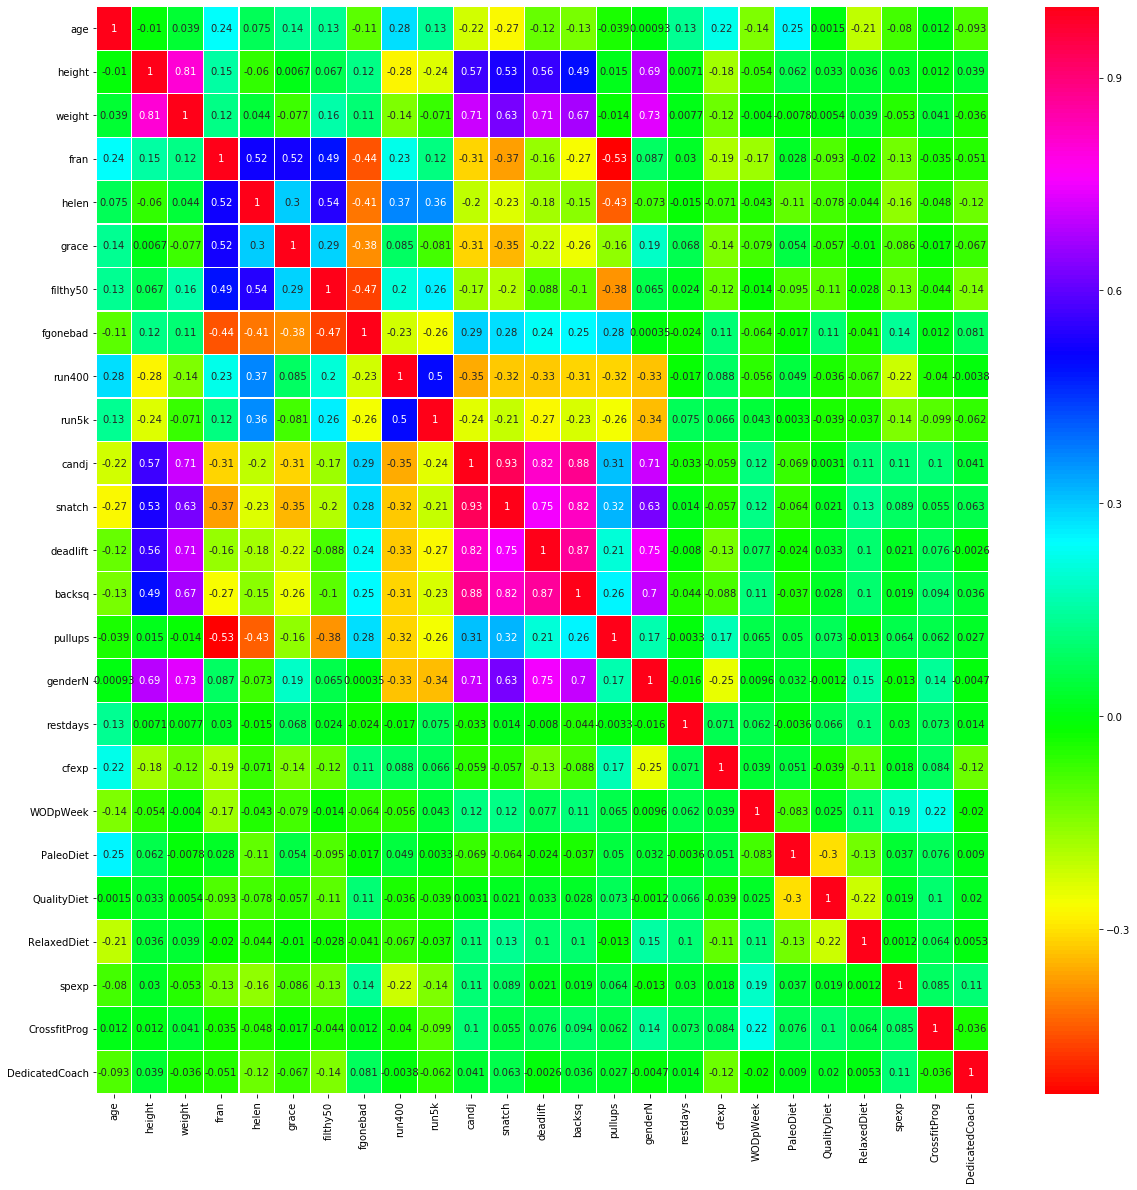

In [20]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(athsplit_df.corr(), 
        xticklabels=athsplit_df.corr().columns,
        yticklabels=athsplit_df.corr().columns, annot=True, linewidths=0.1, cmap="hsv")
fig.savefig("heatmap.png")

<h2>MultiLinReg</h2>

<body>Let's use MultiLinReg to predict the athlete's potential in Olympic lifts based on low skill lifts</body>
<br></br>
<body>Using the Correlation Heatmap, we can see that there's a strong correlation among these lifts</body>

In [21]:
# Create dataframe, for regression
lift_df=athsplit_df[['candj','snatch','deadlift','backsq','weight','genderN']]

In [22]:
#Create Train and Test sets

#Lifts
msk = np.random.rand(len(lift_df)) < 0.90
lift_train = lift_df[msk]
lift_test = lift_df[~msk]

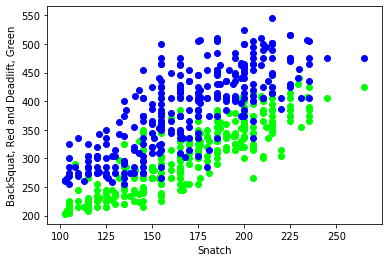

<Figure size 432x288 with 0 Axes>

In [23]:
plt.scatter(lift_train.snatch, lift_train.backsq,  color='lime')
plt.scatter(lift_train.snatch, lift_train.deadlift,  color='blue')
plt.xlabel("Snatch")
plt.ylabel("BackSquat, Red and Deadlift, Green")
plt.show()
plt.savefig("ScatterCorr1.png")

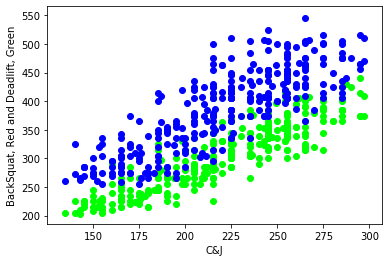

<Figure size 432x288 with 0 Axes>

In [24]:
plt.scatter(lift_train.candj, lift_train.backsq,  color='lime')
plt.scatter(lift_train.candj, lift_train.deadlift,  color='blue')
plt.xlabel("C&J")
plt.ylabel("BackSquat, Red and Deadlift, Green")
plt.show()
plt.savefig("ScatterCorr2.png")

In [25]:
dl=input('How much do you Deadlift?')
dl = int(dl)
bs=input('How much do you Squat?')
bs = int(bs)
bw=input('How much do you weigh?')
bw = int(bw)

How much do you Deadlift? 430
How much do you Squat? 309
How much do you weigh? 200


In [26]:
#MLR for C&J
regr = linear_model.LinearRegression()
x = np.asanyarray(lift_train[['deadlift','backsq','weight']])
y = np.asanyarray(lift_train[['candj']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[0.07226485 0.42543384 0.28827447]]


In [27]:
#Variance score for C&J
y_hat= regr.predict(lift_test[['deadlift','backsq','weight']])
x = np.asanyarray(lift_test[['deadlift','backsq','weight']])
y = np.asanyarray(lift_test[['candj']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 375.72
Variance score: 0.64


In [28]:
testpred = regr.coef_

In [29]:
CnJ = testpred[0,0]*dl + testpred[0,1]*bs + testpred[0,2]*bw
print('You should be able to Clean and Jerk:', CnJ, 'pounds')

You should be able to Clean and Jerk: 220.1878358972163 pounds


In [30]:
#MLR for Snatch
regr = linear_model.LinearRegression()
x = np.asanyarray(lift_train[['deadlift','backsq','weight']])
y = np.asanyarray(lift_train[['snatch']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[0.04703498 0.38054439 0.15239899]]


In [31]:
#Variance score for Snatch
y_hat= regr.predict(lift_test[['deadlift','backsq','weight']])
x = np.asanyarray(lift_test[['deadlift','backsq','weight']])
y = np.asanyarray(lift_test[['snatch']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 386.57
Variance score: 0.45


In [32]:
testpred = regr.coef_

In [33]:
Snatch = testpred[0,0]*dl + testpred[0,1]*bs + testpred[0,2]*bw
print('You should be able to Snatch:', Snatch, 'pounds')

You should be able to Snatch: 168.29305511150443 pounds


In [34]:
#MLR for Potential
regr = linear_model.LinearRegression()
x = np.asanyarray(lift_train[['deadlift','backsq','snatch','candj']])
y = np.asanyarray(lift_train[['weight']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 0.16227104 -0.03787459 -0.15666985  0.43126194]]


In [35]:
#Variance score for Potential
y_hat= regr.predict(lift_test[['deadlift','backsq','snatch','candj']])
x = np.asanyarray(lift_test[['deadlift','backsq','snatch','candj']])
y = np.asanyarray(lift_test[['weight']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 412.52
Variance score: 0.35


In [36]:
testpred = regr.coef_

In [37]:
Weight = testpred[0,0]*dl + testpred[0,1]*bs + testpred[0,2]*bw
Potential = (1-Weight/bw)*100
print('You are at', Potential,'% of your potential')

You are at 86.63033516588294 % of your potential


In [38]:
snw=input('How much do wish to Snatch?')
snw = int(snw)
cjw=input('How much do wish to C&J?')
cjw = int(cjw)

How much do wish to Snatch? 198
How much do wish to C&J? 265


In [39]:
#MLR for Wish Snatch + C&J - DL
regr = linear_model.LinearRegression()
x = np.asanyarray(lift_train[['snatch','candj','weight']])
y = np.asanyarray(lift_train[['deadlift']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
testpred = regr.coef_
DL = testpred[0,0]*snw + testpred[0,1]*cjw + testpred[0,2]*bw
print('Work towards a deadlift of:', DL, 'pounds')

Coefficients:  [[0.06535334 1.10587098 0.67617277]]
Variance score: 0.72
Work towards a deadlift of: 441.23032512167345 pounds


In [40]:
#MLR for Wish Snatch + C&J - DL
regr = linear_model.LinearRegression()
x = np.asanyarray(lift_train[['snatch','candj','weight']])
y = np.asanyarray(lift_train[['backsq']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
testpred = regr.coef_
BS = testpred[0,0]*snw + testpred[0,1]*cjw + testpred[0,2]*bw
print('Work towards a backsquat of:', BS, 'pounds')

Coefficients:  [[0.1794154  1.07418011 0.19775931]]
Variance score: 0.78
Work towards a backsquat of: 359.7338406488573 pounds


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Berlin (~2000 in our initial area of interest which was 12x12km around Alexanderplatz), there are pockets of low restaurant density fairly close to city center. Highest concentration of restaurants was detected north and west from Alexanderplatz, so we focused our attention to areas south, south-east and east, corresponding to boroughs Kreuzberg, Friedrichshain and south-east corner of central Mitte borough. Another borough was identified as potentially interesting (Prenzlauer Berg, north-east from Alexanderplatz), but our attention was focused on Kreuzberg and Friedrichshain which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low restaurant density.

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Alexanderplatz) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with an Italian restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all this is 15 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general and Italian restaurants particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Berlin center but not crowded with existing restaurants (particularly Italian) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

<h3>Clustering for athlete profilling in terms of dietary habits vs age vs gender</h3>

In [41]:
#Select variables
dag_df=athsplit_df[['weight','age','deadlift', 'run5k']]

In [42]:
# Data Normalization
X = dag_df
print(X)

        weight   age  deadlift   run5k
34154    165.0  31.0     500.0  1260.0
34533    219.0  32.0     385.0  1380.0
34661    200.0  34.0     465.0  1445.0
34720    160.0  37.0     419.0  1200.0
34838    183.0  27.0     510.0  1290.0
...        ...   ...       ...     ...
355592   170.0  33.0     305.0  1476.0
362004   196.0  54.0     405.0  1305.0
372328   185.0  55.0     335.0  1363.0
380392   204.0  54.0     345.0  1483.0
382760   225.0  36.0     440.0  1365.0

[342 rows x 4 columns]


In [43]:
#Setup KMeans
k_means = KMeans(init = "k-means++", n_clusters = 8, n_init = 12)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

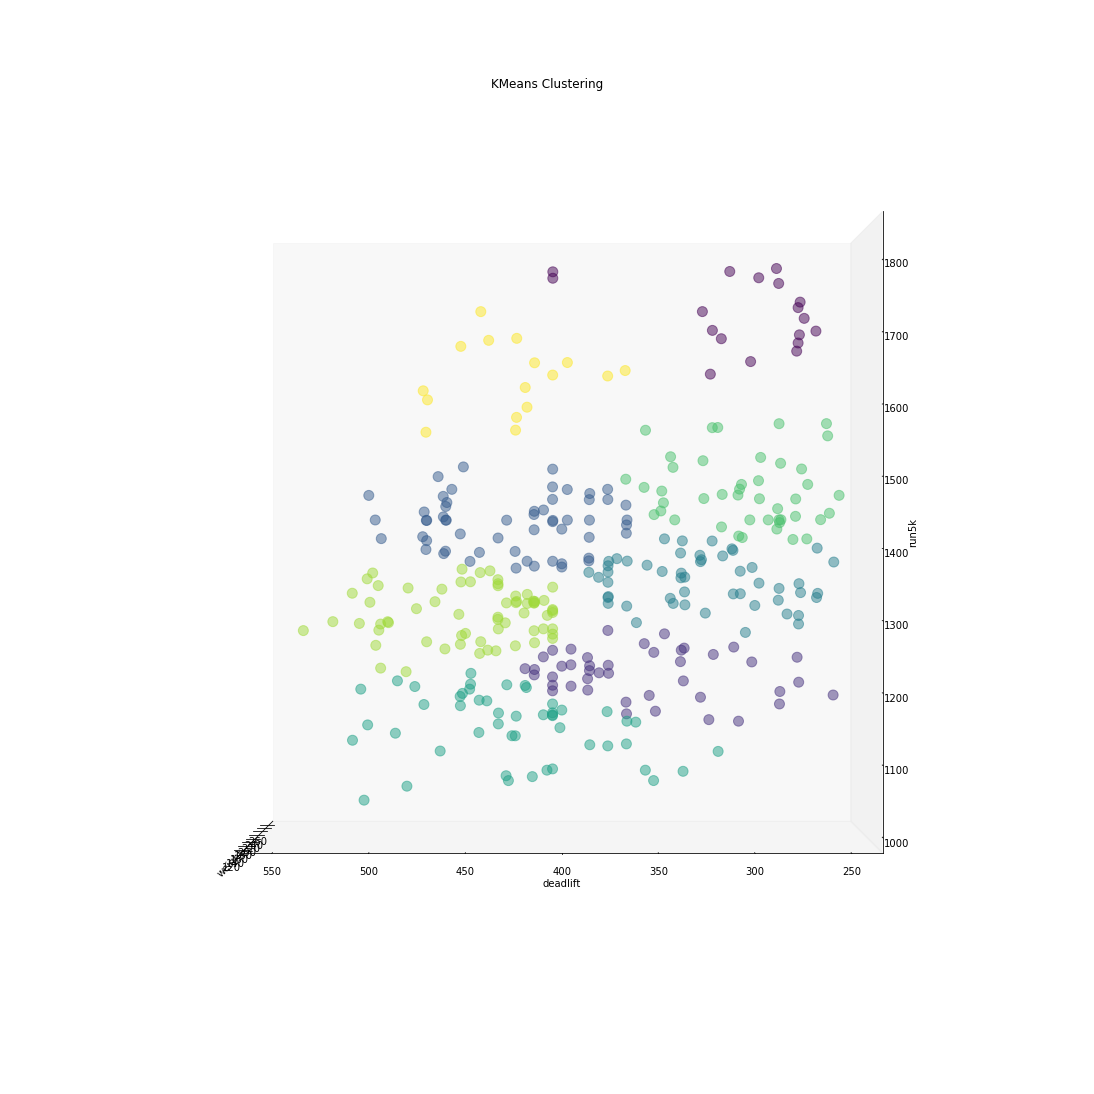

In [44]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=0, azim=180)

plt.cla()
ax.set_xlabel('weight')
ax.set_ylabel('deadlift')
ax.set_zlabel('run5k')
ax.grid(False)
ax.set_title('KMeans Clustering')


ax.scatter(X['weight'], X['deadlift'], X['run5k'], s=100, alpha=0.5, c= k_means_labels.astype(np.float))
fig.savefig("ScatterCluster0.png")

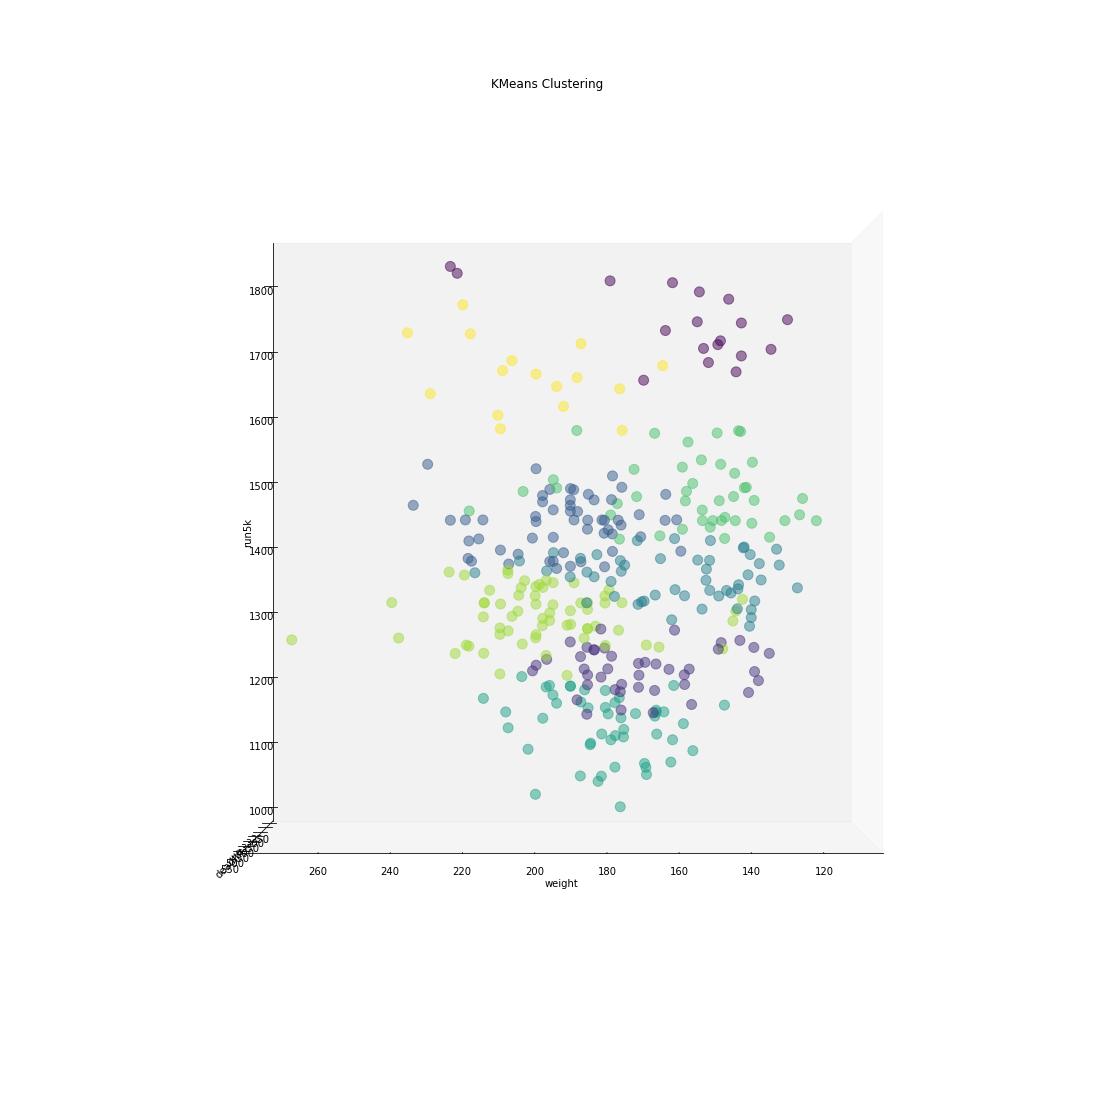

In [45]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=0, azim=90)

plt.cla()
ax.set_xlabel('weight')
ax.set_ylabel('deadlift')
ax.set_zlabel('run5k')
ax.grid(False)
ax.set_title('KMeans Clustering')

ax.scatter(X['weight'], X['deadlift'], X['run5k'], s=100, alpha=0.5, c= k_means_labels.astype(np.float))
fig.savefig("ScatterCluster1.png")

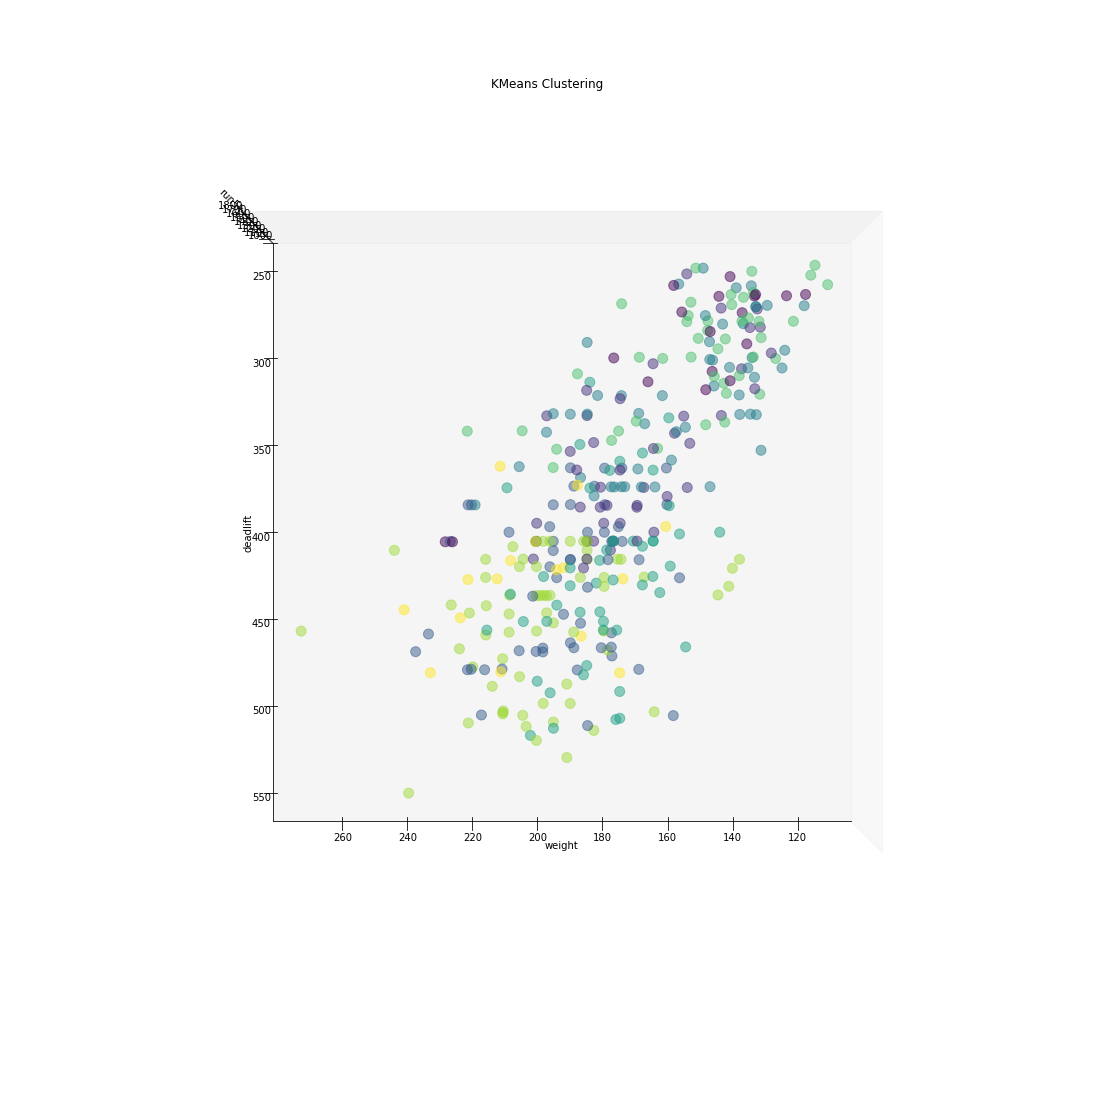

In [46]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=90, azim=90)

plt.cla()
ax.set_xlabel('weight')
ax.set_ylabel('deadlift')
ax.set_zlabel('run5k')
ax.grid(False)
ax.set_title('KMeans Clustering')

ax.scatter(X['weight'], X['deadlift'], X['run5k'], s=100, alpha=0.5, c= k_means_labels.astype(np.float))
fig.savefig("ScatterCluster2.png")

<h3>Clustering for athlete Body Mass Index (weight divided by height squared) and Strength Vs Endurance</h3>

In [47]:
#Select variables
#Select variables
bmi_df=athsplit_df[['weight','height','deadlift', 'run5k']]
bmi_df['BMI'] = bmi_df['weight']*703/(bmi_df['height']*bmi_df['height'])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [48]:
# Set X
X = bmi_df
print(X)

        weight  height  deadlift   run5k        BMI
34154    165.0    64.0     500.0  1260.0  28.319092
34533    219.0    76.0     385.0  1380.0  26.654605
34661    200.0    70.0     465.0  1445.0  28.693878
34720    160.0    70.0     419.0  1200.0  22.955102
34838    183.0    70.0     510.0  1290.0  26.254898
...        ...     ...       ...     ...        ...
355592   170.0    67.0     305.0  1476.0  26.622856
362004   196.0    73.0     405.0  1305.0  25.856258
372328   185.0    73.0     335.0  1363.0  24.405142
380392   204.0    76.0     345.0  1483.0  24.828947
382760   225.0    72.0     440.0  1365.0  30.512153

[342 rows x 5 columns]


In [49]:
#Setup KMeans
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

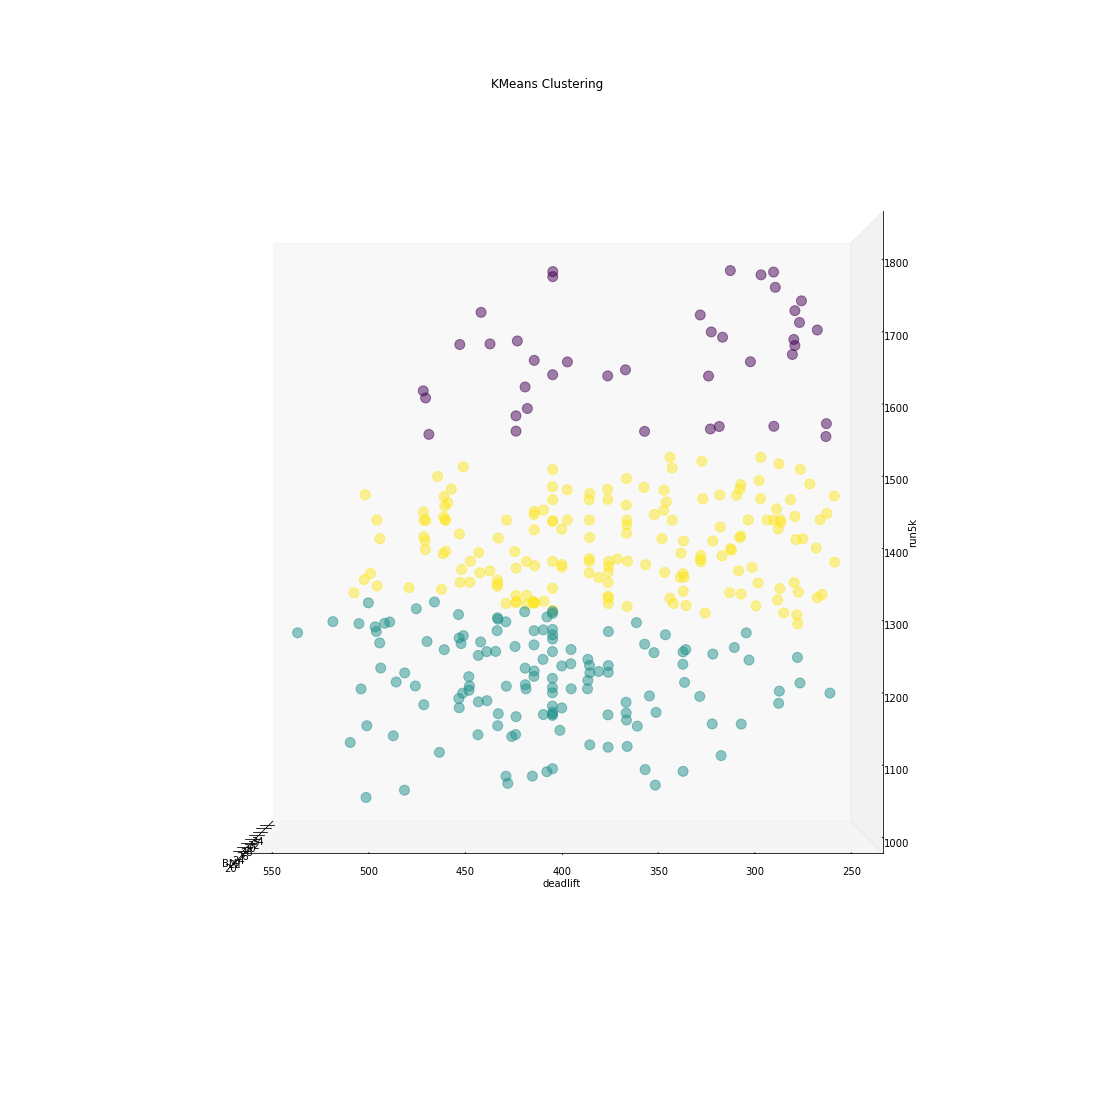

In [50]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=0, azim=180)

plt.cla()
ax.set_xlabel('BMI')
ax.set_ylabel('deadlift')
ax.set_zlabel('run5k')
ax.grid(False)
ax.set_title('KMeans Clustering')


ax.scatter(X['BMI'], X['deadlift'], X['run5k'], s=100, alpha=0.5, c= k_means_labels.astype(np.float))
fig.savefig("ScatterCluster_BMI.png")